In [1]:
%matplotlib inline

import os
import random

from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import professor as prof

import seaborn as sns

import numpy as np
import pandas as pd
import cv2
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
# get the list of filenames in a given directory

camera_view = 'KL11-E1DC'

availible_ids = [int(file.split('.')[0])
                 for file in os.listdir(f"./data/real/{camera_view}/") 
                 if file.endswith(".png")]

print(f'number of unique images: {len(availible_ids)}')
print(f'number of pairs: {len(availible_ids)*len(availible_ids)-1}')

number of unique images: 109
number of pairs: 11880


## Operations

In [45]:
def downsample(img):
    return cv2.pyrDown(img)

In [6]:
def correct_contrast(img, clip_limit=3.2, tile_size=5):
    
    # create the object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, 
                            tileGridSize=(tile_size, tile_size))
    
    # apply equalisation
    return clahe.apply(img)

In [7]:
def nlm_filter(img, strength=7.4, window_size=4):
    return cv2.fastNlMeansDenoising(img, h=strength, searchWindowSize=window_size)

In [9]:
def blur(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

In [18]:
def noise(img):
    isNoise = 0
    i = 0
    j = 0
    criticalValue = 0.4
    for row in img:
        for col in row:
            if(j+1 == len(row)):
                break
            elif(np.abs(img[i,j]) == 0 or np.abs(img[i,j+1]) == 0):
                pass
            elif(np.abs(1 - int(img[i,j])/(int(img[i,j+1]))) > criticalValue):
                isNoise += 1
            j +=1
        i +=1
    return isNoise

In [70]:
def draw_image_histogram(image, channels):
    hist = cv2.calcHist([image], channels, None, [256], [0, 256])
    hist = cv2.normalize(hist, None)
    return hist

In [12]:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.0*sigma**2))

In [69]:
def hist_params(img):
    histImage = draw_image_histogram(img, [0])
    bin_centres = np.arange(0,len(histImage))
    histImage = np.array([i[0] for i in histImage])
    mean = sum(bin_centres * histImage)
    sigma = sum(bin_centres * (histImage - mean)**2)
    
    p0 = [1.0, 126, 50]
    coeff, var_matrix = curve_fit(gauss, bin_centres, histImage, p0=p0)
    
    return coeff[1], coeff[2], mean

In [46]:
training_images = []
N = len(availible_ids)

for i in range(0,N):
    img_id = availible_ids[i]
    training_images.append(cv2.imread(f'./data/real/{camera_view}/{img_id}.png', 
                      cv2.IMREAD_GRAYSCALE))

downsampled = []
for image in training_images:
    downsampled.append(downsample(image))

# Nearest neighbours in preprocessing

Using all parameters investigated with just the original images and then by eye, we can see if they look the same.

In [71]:
params = []

for image in training_images:
    loc = []
    loc.append(noise(image))
    mean, var, skmean = hist_params(image)
    skew = mean - skmean
    loc.append(mean)
    loc.append(var)
    loc.append(skew)
    loc.append(blur(image))
    params.append(loc)

Run a nearest neighbour algorithm to see if there is any correlation between the nearest neighbour images.

In [72]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(params)
distances, indices = nbrs.kneighbors(params)
print(indices[0],
indices[1],
indices[2],
indices[3])
print(distances[0],
     distances[1],
     distances[2],
     distances[3])

[ 0 78] [1 8] [ 2 27] [ 3 93]
[ 0.         30.04416699] [ 0.         96.23229741] [ 0.         63.96457915] [ 0.         47.90130567]


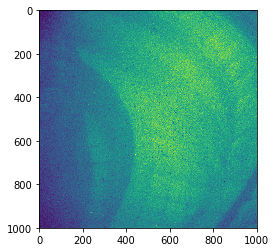

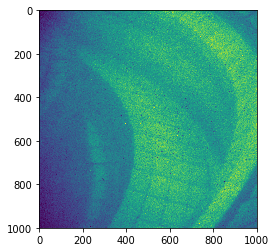

In [61]:
plt.imshow(training_images[0])
plt.show()
plt.imshow(training_images[78])
plt.show()

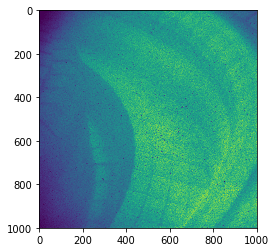

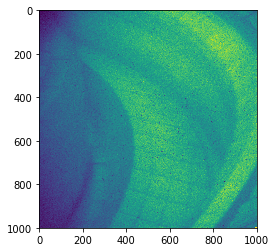

In [73]:
plt.imshow(training_images[1])
plt.show()
plt.imshow(training_images[8])
plt.show()

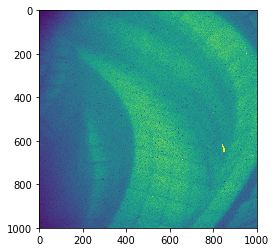

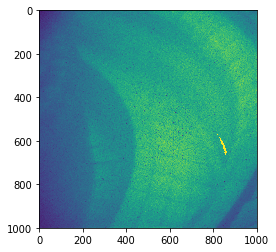

In [74]:
plt.imshow(training_images[2])
plt.show()
plt.imshow(training_images[27])
plt.show()

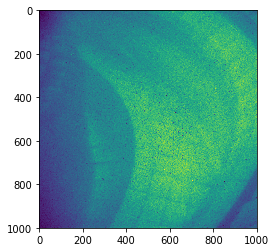

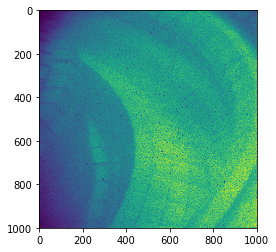

In [75]:
plt.imshow(training_images[3])
plt.show()
plt.imshow(training_images[93])
plt.show()

These all look alright so far, but is hard to tell without putting them all through the same preprocessing. One thing I would say is that from the distances given between images in this parameter space, we would expect the first set of images to be the most similar, but I think this is questionable. As a comparison, below is the same analysis but with the downsampled images.

In [76]:
params = []

for image in downsampled:
    loc = []
    loc.append(noise(image))
    mean, var, skmean = hist_params(image)
    skew = mean - skmean
    loc.append(mean)
    loc.append(var)
    loc.append(skew)
    loc.append(blur(image))
    params.append(loc)

In [77]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(params)
distances, indices = nbrs.kneighbors(params)
print(indices[0],
indices[1],
indices[2],
indices[3])
print(distances[0],
     distances[1],
     distances[2],
     distances[3])

[ 0 43] [ 1 10] [ 2 30] [ 3 17]
[ 0.        19.2577168] [ 0.         15.84386158] [ 0.        16.2768356] [0.         6.57607469]


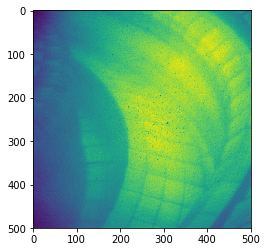

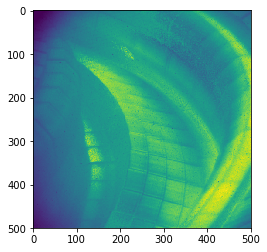

In [78]:
plt.imshow(downsampled[0])
plt.show()
plt.imshow(downsampled[43])
plt.show()

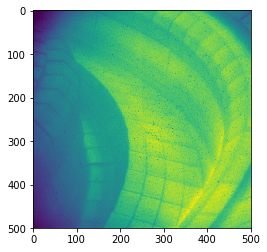

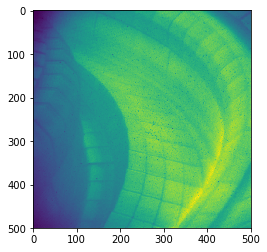

In [79]:
plt.imshow(downsampled[1])
plt.show()
plt.imshow(downsampled[10])
plt.show()

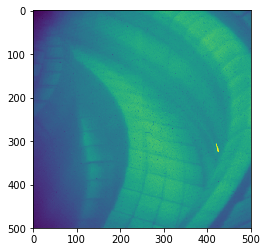

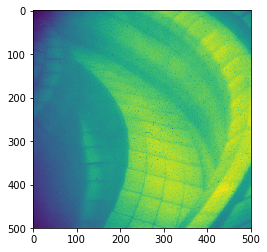

In [81]:
plt.imshow(downsampled[2])
plt.show()
plt.imshow(downsampled[30])
plt.show()

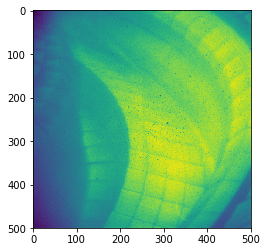

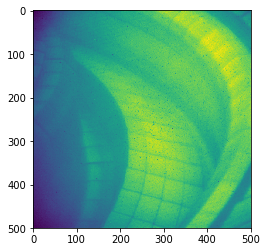

In [80]:
plt.imshow(downsampled[3])
plt.show()
plt.imshow(downsampled[17])
plt.show()

These all look fairly different and so I think from this, if this approach is going to work we would need to group them before any downsampling of the images.

# Optimisation with 1 operation (correct_contrast)

NameError: name 'I' is not defined

## DeepMatching results

# Optimisation with 2 operations (correct_contrast, nlm_filter)

## DeepMatching results